In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, MaxPooling2D, Flatten, Dropout, Conv2D
import os
from sklearn.model_selection import train_test_split
import collections
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from io import BytesIO
from IPython.display import FileLink
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_path = "/content/drive/MyDrive/SKRIPSI/train"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [3]:
def get_dataset_path(base_path):
    classes = sorted(os.listdir(base_path))
    file_paths = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(base_path, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(class_dir, file_name))
                labels.append(i)

    return file_paths, labels, classes

In [4]:
file_paths, labels, class_names = get_dataset_path(base_path)

print(f"Found {len(file_paths)} images in {len(class_names)} classes.")

Found 12669 images in 6 classes.



Distribusi Kelas:
         Jumlah Sample
Kelas                 
Residu            3044
Plastik           2122
Kertas            2055
Logam             1978
Kaca              1956
Kardus            1514

Total Sample: 12669


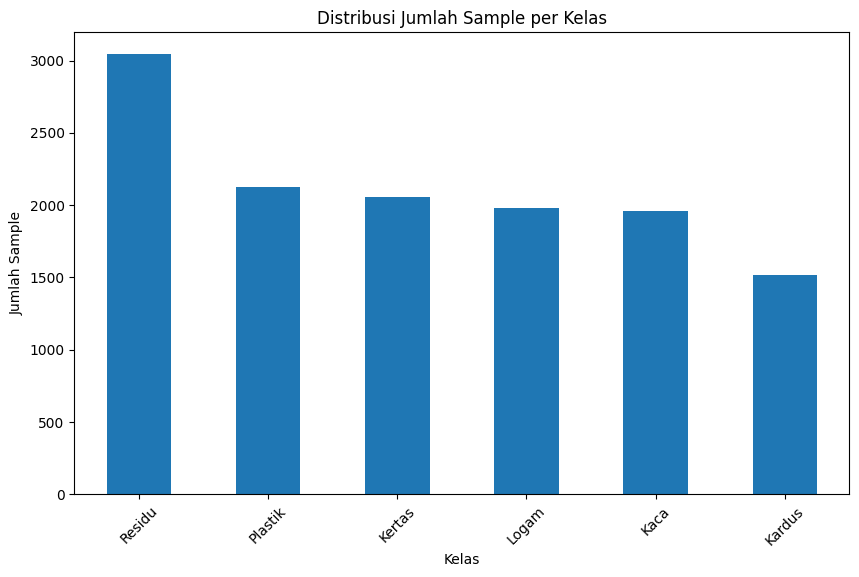

In [5]:
from pathlib import Path
import pandas as pd



# Hitung jumlah file per kelas
main_folder_path = Path(base_path)
all_folders = [d for d in main_folder_path.glob('*/') if d.is_dir()]  # Hanya subfolder langsung

data = []
for folder in all_folders:
    folder_name = folder.name
    # Hitung hanya file gambar (modifikasi pattern sesuai kebutuhan)
    file_count = len([
        f for f in folder.glob('*')
        if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png']
    ])
    data.append({'Kelas': folder_name, 'Jumlah Sample': file_count})

# Buat DataFrame dan tampilkan
count_df = pd.DataFrame(data).sort_values('Jumlah Sample', ascending=False)
count_df = count_df.set_index('Kelas')
print("\nDistribusi Kelas:")
print(count_df)
print(f"\nTotal Sample: {count_df['Jumlah Sample'].sum()}")

# Visualisasi (opsional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
count_df['Jumlah Sample'].plot(kind='bar')
plt.title('Distribusi Jumlah Sample per Kelas')
plt.ylabel('Jumlah Sample')
plt.xticks(rotation=45)
plt.show()

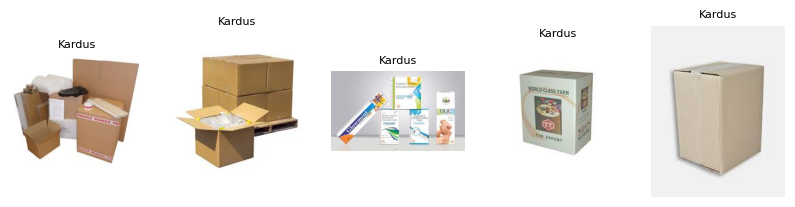

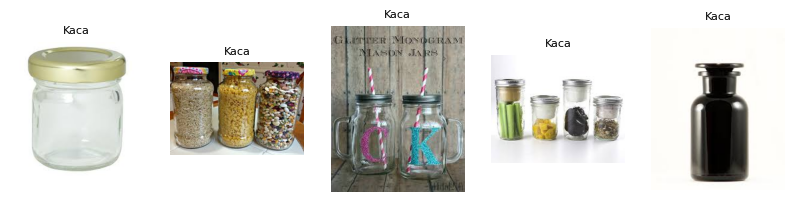

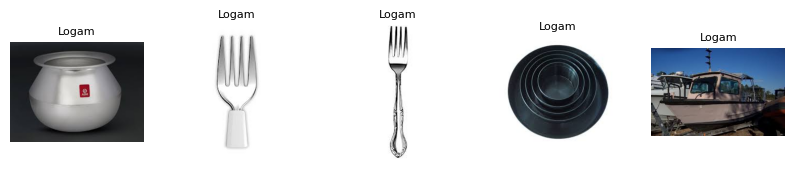

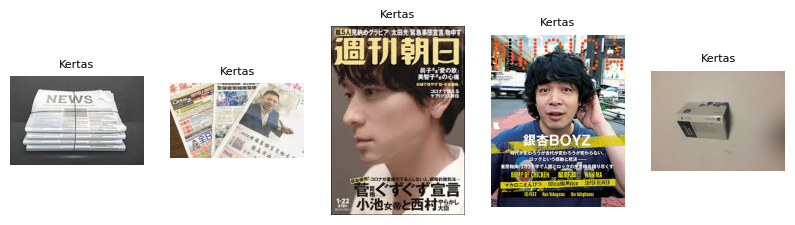

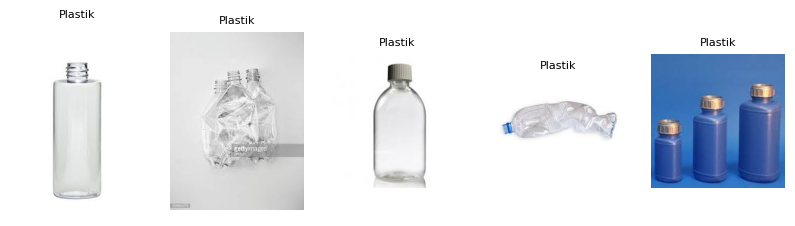

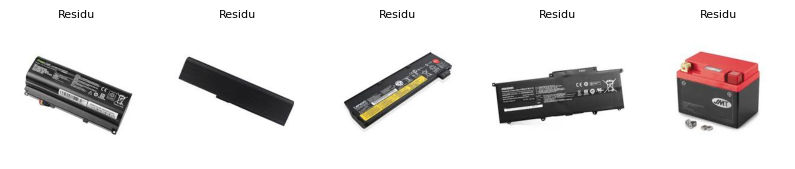

In [6]:
def plot_images(item_dir):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]
    plt.figure(figsize=(10, 10))
    for image_id, image_path in enumerate(item_files):
        plt.subplot(1, 5, image_id+1)
        img = plt.imread(image_path)
        plt.axis('off')
        plt.imshow(img)
        plt.title(os.path.basename(item_dir), fontsize=8)

categories = ["Kardus", "Kaca", "Logam", "Kertas", "Plastik", "Residu"]
for category in categories:
    plot_images(os.path.join(base_path, category))

**Pre-Processing**

In [7]:
def prep_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

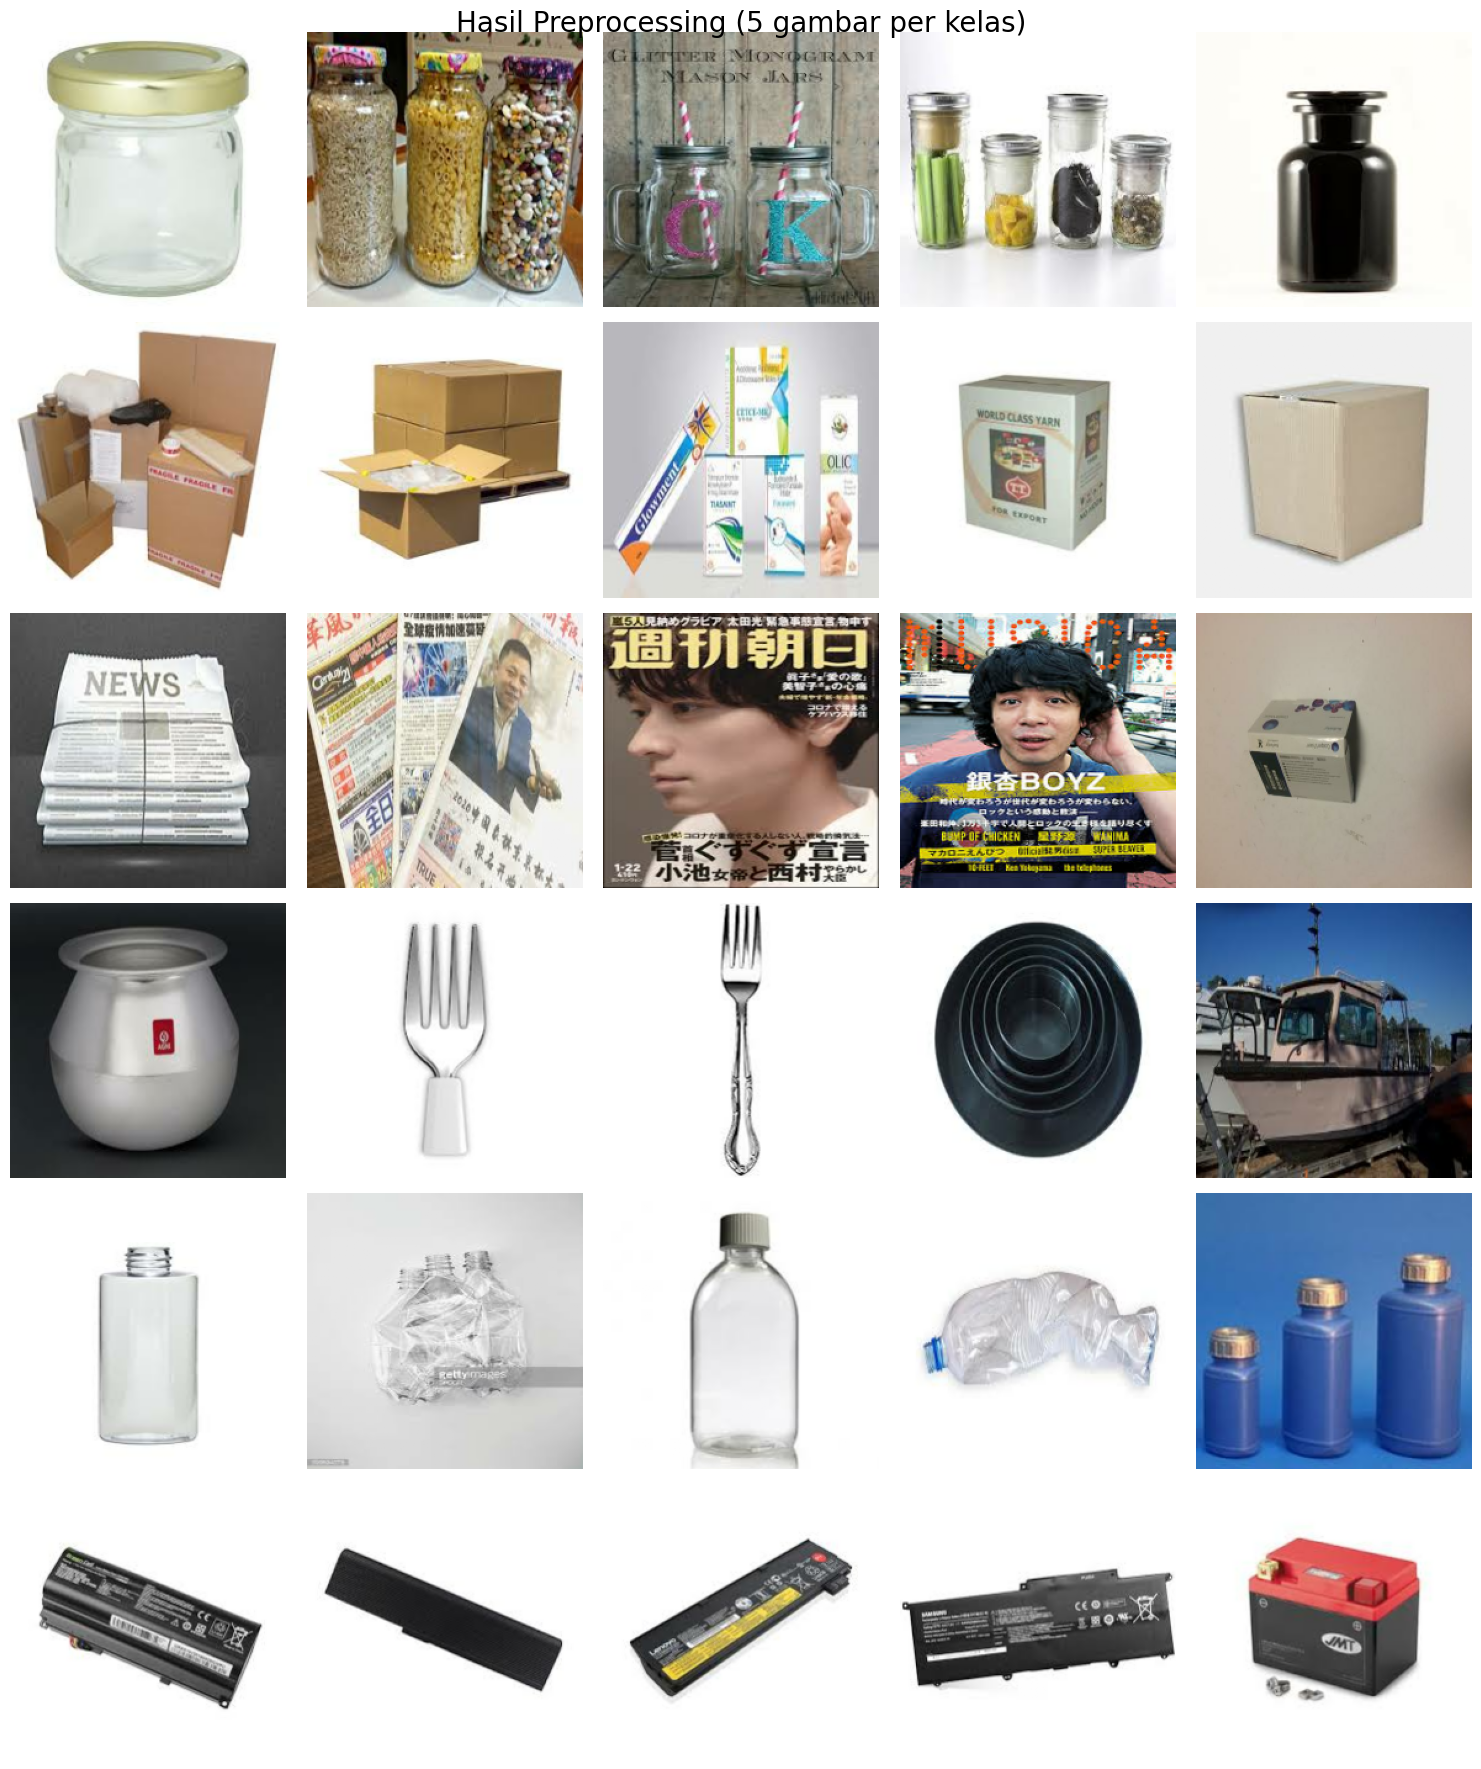

In [8]:
# ============================================================
# Visualisasi hasil Preprocessing (5 gambar per kelas)
# ============================================================
import matplotlib.pyplot as plt

num_samples = 5  # jumlah gambar per kelas

plt.figure(figsize=(15, len(class_names) * 3))

for class_id, class_name in enumerate(class_names):
    # Ambil file path untuk kelas tertentu
    sample_images = [fp for fp, lb in zip(file_paths, labels) if lb == class_id][:num_samples]

    for i, img_path in enumerate(sample_images):
        # Apply preprocessing
        img_tensor, _ = prep_image(img_path, class_id)
        img = img_tensor.numpy()

        # Plot di grid: baris = kelas, kolom = gambar
        plt.subplot(len(class_names), num_samples, class_id * num_samples + i + 1)
        plt.imshow(img)
        plt.axis("off")
        if i == 0:  # kasih label kelas di gambar pertama
            plt.ylabel(class_name, fontsize=12)

plt.suptitle("Hasil Preprocessing (5 gambar per kelas)", fontsize=20)
plt.tight_layout()
plt.show()


In [9]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

In [10]:
def create_dataset(file_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(prep_image, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size = 1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

In [11]:
train_dataset = create_dataset(train_paths, train_labels)
test_dataset = create_dataset(test_paths, test_labels)
val_dataset = create_dataset(val_paths, val_labels)

**AUGMENTASI**

In [12]:
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    return img, label

train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

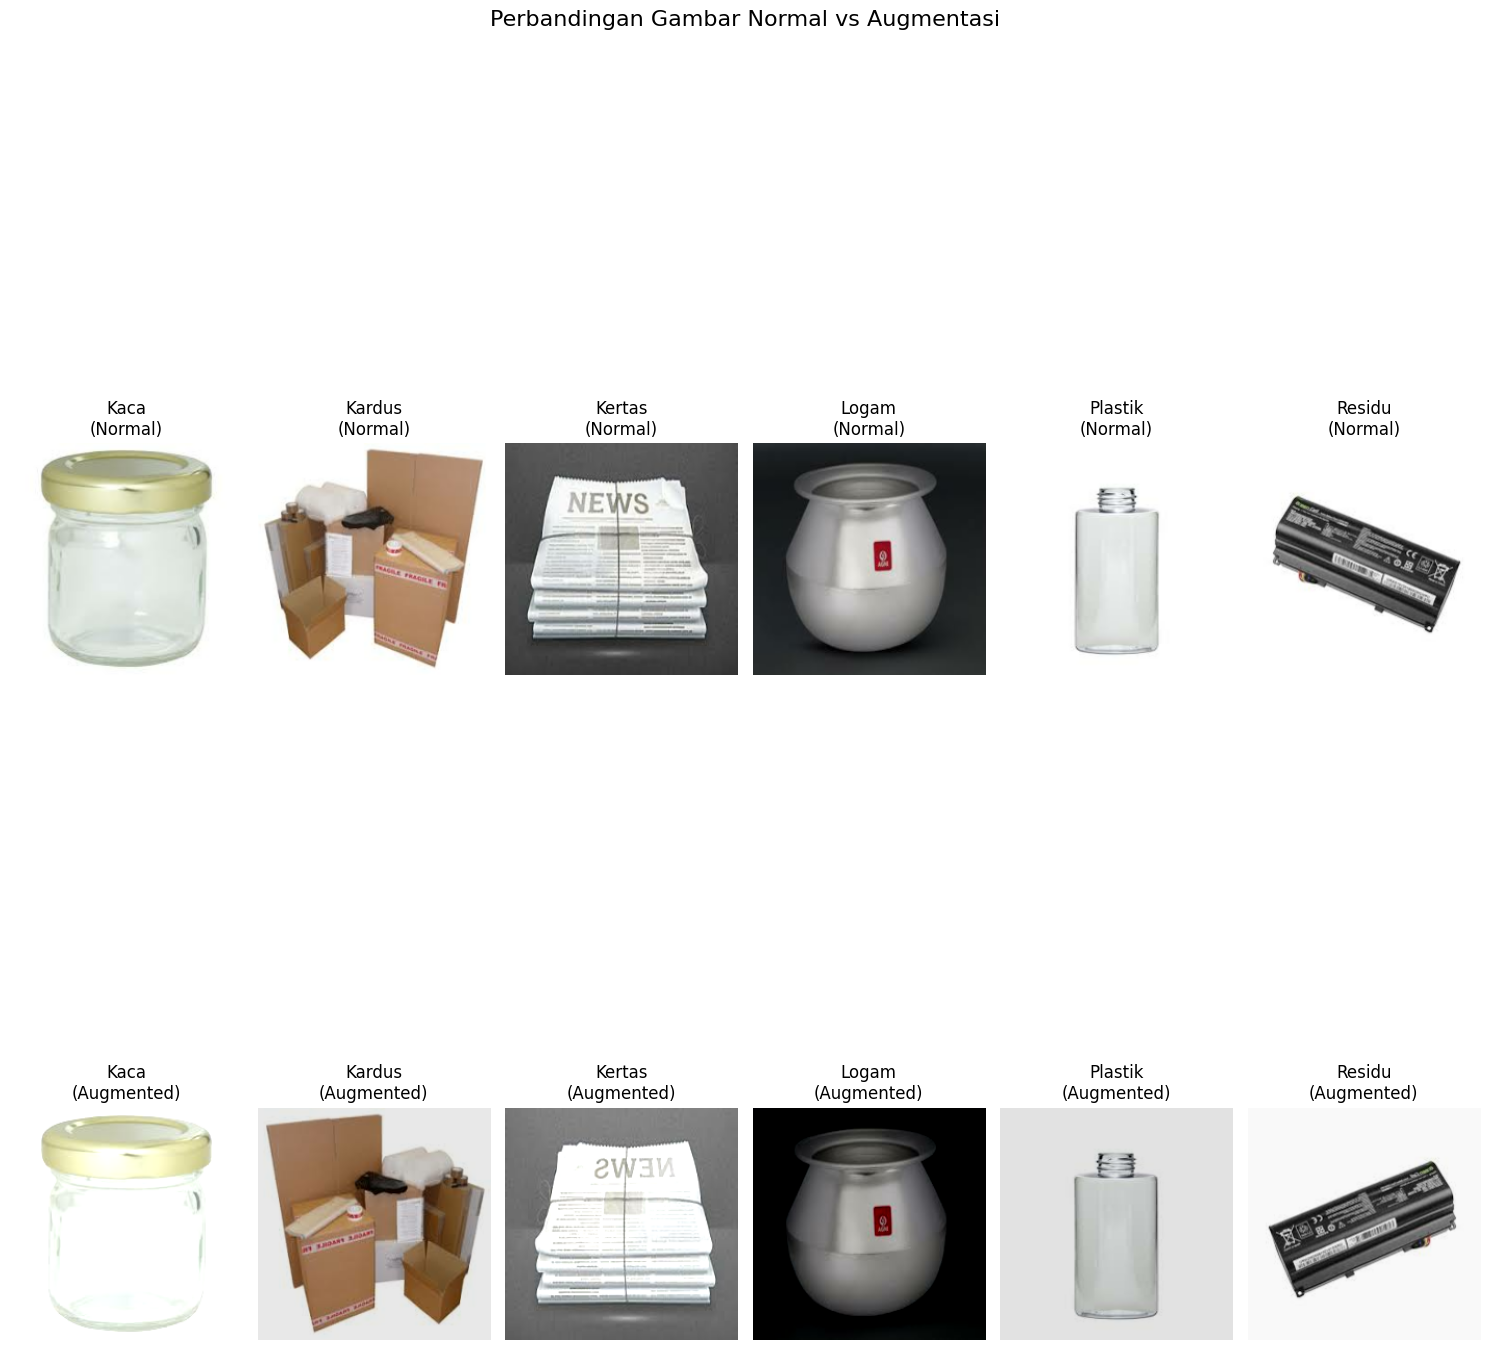

In [13]:
# ============================================================
# Visualisasi Perbandingan Preprocessing vs Augmentasi
# (1 gambar per kelas)
# ============================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(15, len(class_names) * 3))

for class_id, class_name in enumerate(class_names):
    # Ambil 1 gambar dari kelas tertentu
    img_path = [fp for fp, lb in zip(file_paths, labels) if lb == class_id][0]

    # Apply preprocessing (normal)
    img_tensor, _ = prep_image(img_path, class_id)
    img_normal = img_tensor.numpy()

    # Apply augmentasi
    aug_img, _ = augment_image(img_tensor, class_id)
    img_aug = aug_img.numpy()

    # Plot gambar normal (baris 1)
    plt.subplot(2, len(class_names), class_id + 1)
    plt.imshow(img_normal)
    plt.axis("off")
    plt.title(f"{class_name}\n(Normal)")

    # Plot gambar augmented (baris 2)
    plt.subplot(2, len(class_names), len(class_names) + class_id + 1)
    plt.imshow(img_aug)
    plt.axis("off")
    plt.title(f"{class_name}\n(Augmented)")

plt.suptitle("Perbandingan Gambar Normal vs Augmentasi", fontsize=16)
plt.tight_layout()
plt.show()


**MODEL**

In [14]:
def build_model(num_classes):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
    base_model.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [15]:
num_classes = len(class_names)
model = build_model(num_classes)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 2,388,614 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from google.colab import drive
import os
import tensorflow as tf

# === 1. Hitung Class Weights ===
# pastikan train_labels = array 1D label kelas (bukan one-hot)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# === 2. Training Model ===
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# === 3. Mount Google Drive ===
drive.mount('/content/drive')

# === 4. Simpan Model ke Google Drive hanya dalam format TFLite ===
save_dir = '/content/drive/MyDrive/Colab Notebooks/NEW'
os.makedirs(save_dir, exist_ok=True)

tflite_path = os.path.join(save_dir, "model_fix.tflite")

# Convert ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # opsional untuk kecilkan ukuran
tflite_model = converter.convert()

# Simpan ke file .tflite
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print(f" Model TFLite disimpan di: {tflite_path}")


Epoch 1/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 823s 2s/step - accuracy: 0.2802 - loss: 1.9002 - val_accuracy: 0.5651 - val_loss: 1.1166 - learning_rate: 1.0000e-05
Epoch 2/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.5817 - loss: 1.0916 - val_accuracy: 0.7238 - val_loss: 0.7659 - learning_rate: 1.0000e-05
Epoch 3/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.6971 - loss: 0.8324 - val_accuracy: 0.7916 - val_loss: 0.5978 - learning_rate: 1.0000e-05
Epoch 4/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.7672 - loss: 0.6652 - val_accuracy: 0.8208 - val_loss: 0.5106 - learning_rate: 1.0000e-05
Epoch 5/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8001 - loss: 0.5720 - val_accuracy: 0.8374 - val_loss: 0.4429 - learning_rate: 1.0000e-05
Epoch 6/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8191 - loss: 0.5127 - val_accuracy: 0.8532 - val_loss: 0.3961 - learning_rate: 1.0000e-05
Epoch 7/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step

In [19]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 410ms/step - accuracy: 0.9095 - loss: 0.2744
Test Accuracy: 91.79%


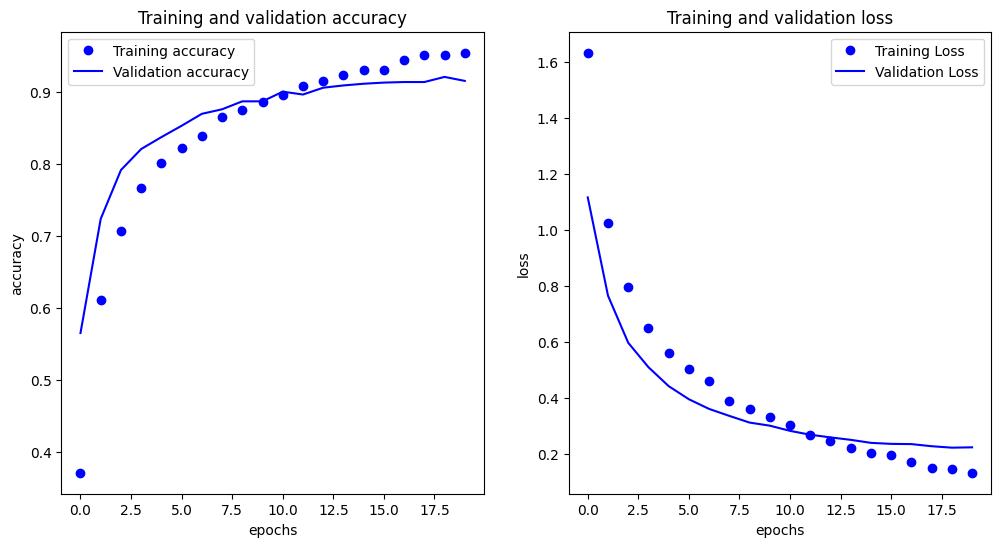

In [20]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

In [21]:
import keras.utils as ku

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Probability: 0.99862975
Classified: Residu 



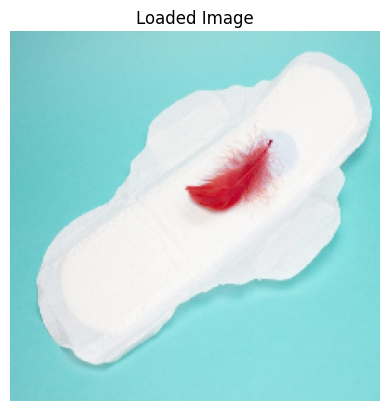

In [23]:


# Dictionary untuk klasifikasi
number_to_class = {
    0: 'Besi',
    1: 'Kaca',
    2: 'Kardus',
    3: 'Kertas',
    4: 'Plastik',
    5: 'Residu'
}

# Load dan preprocess gambar
test_img = 'coba.jpg'
img = ku.load_img(test_img, target_size=(224, 224))
img = ku.img_to_array(img, dtype=np.uint8)
img = np.array(img) / 255.0

# Prediksi dengan model
prediction = model.predict(img[np.newaxis, ...])

# Hasil klasifikasi
print("Probability:", np.max(prediction[0], axis=-1))
predicted_class = number_to_class[np.argmax(prediction[0], axis=-1)]
print("Classified:", predicted_class, '\n')

# Tampilkan gambar
plt.axis('off')
plt.imshow(img.squeeze())
plt.title("Loaded Image")
plt.show()


In [25]:
import os
import shutil
import random

# Path dataset utama
dataset_path = "/content/drive/MyDrive/SKRIPSI"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")


if not os.path.exists(train_path):
    raise FileNotFoundError(f"Path '{train_path}' tidak ditemukan. Periksa lokasi dataset!")


if not os.path.exists(test_path):
    os.makedirs(test_path)


test_ratio = 0.2  # 20% dari total data


for class_name in os.listdir(train_path):
    class_train_path = os.path.join(train_path, class_name)
    class_test_path = os.path.join(test_path, class_name)


    if not os.path.exists(class_test_path):
        os.makedirs(class_test_path)


    images = [img for img in os.listdir(class_train_path) if img.endswith(('.jpg', '.png', '.jpeg'))]


    if len(images) == 0:
        print(f"Peringatan: Tidak ada gambar di '{class_train_path}', lewati kelas ini.")
        continue

    num_test_samples = int(len(images) * test_ratio)

    # Pilih gambar secara acak
    test_images = random.sample(images, num_test_samples)

    # Pindahkan gambar ke folder test
    for img in test_images:
        src_path = os.path.join(class_train_path, img)
        dest_path = os.path.join(class_test_path, img)

        shutil.copy2(src_path, dest_path)

print("Dataset uji berhasil dibuat!")



Dataset uji berhasil dibuat!


In [26]:
import os

test_path = "/content/drive/MyDrive/SKRIPSI/test"

# Periksa jumlah gambar per kelas
for class_name in os.listdir(test_path):
    class_test_path = os.path.join(test_path, class_name)
    num_images = len(os.listdir(class_test_path))
    print(f"Kelas {class_name}: {num_images} gambar")


Kelas Kaca: 391 gambar
Kelas Kardus: 302 gambar
Kelas Kertas: 411 gambar
Kelas Logam: 395 gambar
Kelas Plastik: 424 gambar
Kelas Residu: 607 gambar


Found 2530 images belonging to 6 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step


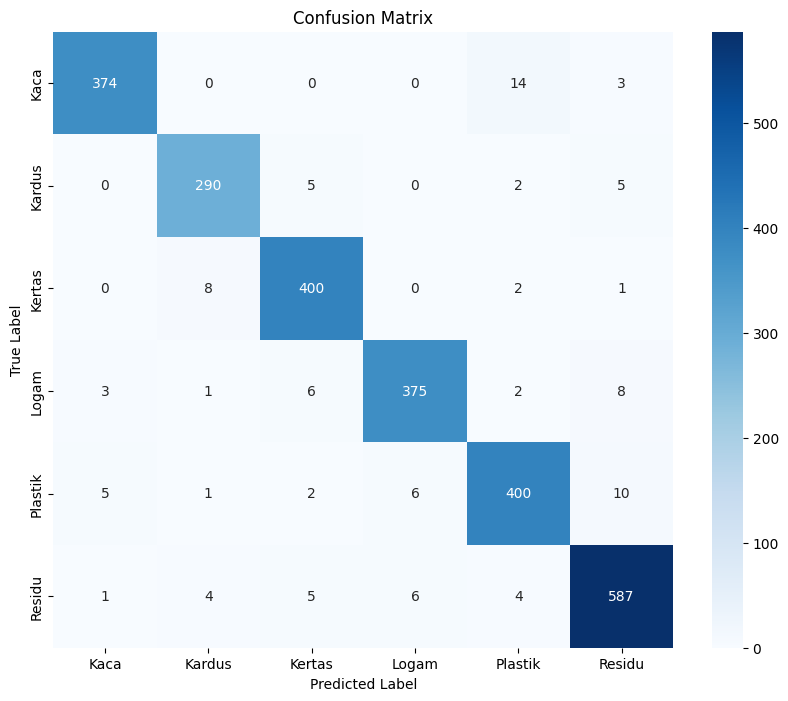


Classification Report:
              precision    recall  f1-score   support

        Kaca       0.98      0.96      0.97       391
      Kardus       0.95      0.96      0.96       302
      Kertas       0.96      0.97      0.97       411
       Logam       0.97      0.95      0.96       395
     Plastik       0.94      0.94      0.94       424
      Residu       0.96      0.97      0.96       607

    accuracy                           0.96      2530
   macro avg       0.96      0.96      0.96      2530
weighted avg       0.96      0.96      0.96      2530



In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Buat ImageDataGenerator untuk dataset uji
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Prediksi model pada dataset uji
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Ambil label sebenarnya
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Buat Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))
